# RANSAC Tutorial

This notebook contains a simple demonstration of the RANdom SAmpling Consensus (RANSAC) algorithm. While old, it is provided as a demonstration of a method that attempts to work around noisy data.

* First, read the classic paper, [here](https://dl.acm.org/doi/pdf/10.1145/358669.358692).
* Second, read the online course notes, [here](https://mphy0026.readthedocs.io/en/latest/calibration/ransac.html).

The aim of this notebook, is to illustrate the main points of the Fischler, Bolles paper, just fitting data to a line. We also have an additional notebook, [here](https://mphy0026.readthedocs.io/en/latest/notebooks/RANSAC.html), that shows how this is applied to pivot calibration.

**Note:** The code in this notebook is meant to be simple and easy to read, not efficient.

In [98]:
%matplotlib inline

In [99]:
# Jupyter notebook sets the cwd to the folder containing the notebook.
# So, you want to add the root of the project to the sys path, so modules load correctly.
import sys
sys.path.append("../../")

In [100]:
# All imports
import numpy as np
import matplotlib.pyplot as plt

# Zero-mean Gaussian noise.
So, imagine we had some data, that should fit to a line, but its corrupted by a small bit of noise.

In [101]:
# Reference data for initial line-fitting test, fitting data to y=mx + c.
number_of_samples = 100
ref_m = 1
ref_c = 5
sigma = 2

m=1.0037316008860027, c=4.9589812721009


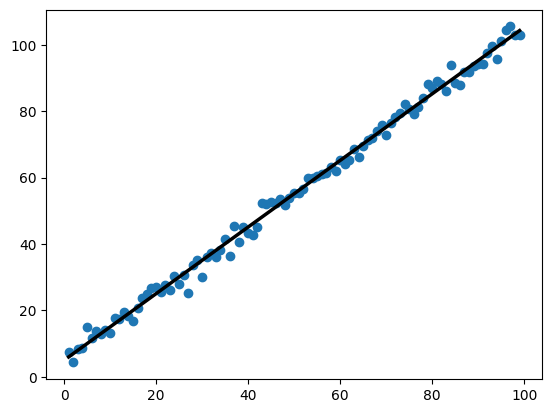

In [102]:
# Now:
# 1. create samples based on a line.
# 2. Add random gaussian noise in y to simulate measurement error.
# 3. Fit a line to the data.
x_array = np.arange(1, number_of_samples)
y_array = []
for x in x_array:
    value = ref_m * x + ref_c
    value += np.random.normal(0, sigma)
    y_array.append(value)
    
m, c = np.polyfit(x_array, y_array, deg=1)
print("m=" + str(m) + ", c=" + str(c))
plt.scatter(x_array, y_array)
plt.plot(x_array, c + m * x_array, color="k", lw=2.5)
plt.show()

# Outlier Data
Try re-running, the same cell over and over. You can see that the fit of the line is reasonable, as long as the noise is random, zero-mean, and fairly small sigma (<1.0).

But what if, occasionally, we get a rediculous spike in noise, i.e. representing some kind of a device or measurement failure? Try running the cell below, and you get quite vastly different results!

m=1.3792878631632493, c=8.194608938811692


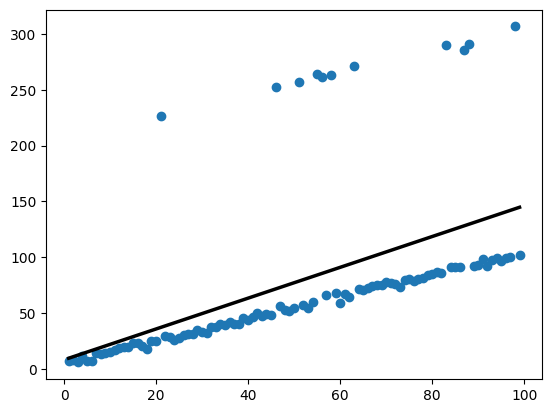

In [107]:
# Now:
# 1. create samples based on a line.
# 2. Add random gaussian noise in y to simulate measurement error.
# 3. With a certain probability (fail_probability), add errors that are (fail_magnitude) times worse.
# 4. Fit a line to the data.
fail_probability = 0.10
fail_magnitude = 100

x_array = np.arange(1, number_of_samples)
y_array = []
for x in x_array:
    value = ref_m * x + ref_c
    
    noise = np.random.normal(0, sigma)
    likelihood = np.random.uniform(0, 1)
    
    value += noise 
    if likelihood < fail_probability:
        # Deliberately adding large positive numbers.
        spike = sigma * fail_magnitude
        value += spike
    y_array.append(value)
    
m, c = np.polyfit(x_array, y_array, deg=1)
print("m=" + str(m) + ", c=" + str(c))
plt.scatter(x_array, y_array)
plt.plot(x_array, c + m * x_array, color="k", lw=2.5)
plt.show()

# The RANSAC algorithm in English

1. Pick the minimum number of datapoints to solve your problem (e.g. fit a line, compute 3D/2D pose)
2. Fit the model (e.g. for a line, that means, compute slope and intercept)
3. For a given distance threshold, count how many data samples 'agree with' that model, i.e. it's like they are voting for that model, i.e. a consensus. In terms of a line, it just means, 'they are close to the line'.
4. If the number of votes is greater than another threshold, then compute the model using that consensus set.
5. If the number of votes is less than this threshold, go to 1.
6. If after a certain number of iterations, no solution has been found, compute the model with the largest set so far, or fail.

m=1.0000658856550042, c=5.3643822445749, votes=88


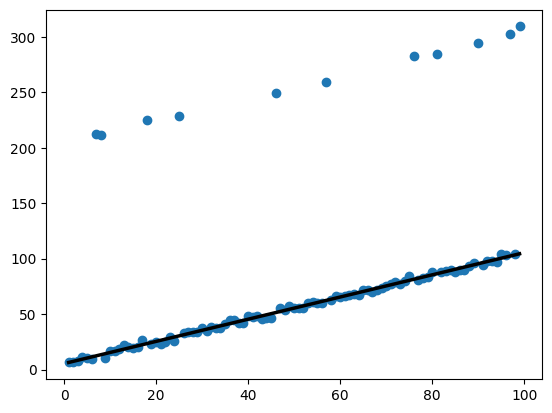

In [105]:
consensus_threshold = 5
size_threshold = number_of_samples * 0.50
number_of_iterations = 10
most_votes = 0
best_m = None
best_c = None
# Now solve the line-fitting using RANSAC.
for i in range(number_of_iterations):
    
    # Need a minimum of 2 samples to fit a line, but use 3, to average out the baseline noise.
    indexes = np.random.randint(0, len(x_array), 3)
    new_x_array = [x_array[x] for x in indexes]
    new_y_array = [y_array[y] for y in indexes]
    m, c = np.polyfit(new_x_array, new_y_array, deg=1)

    # Now for each model, measure consensus set.
    votes = 0
    tmp_x = []
    tmp_y = []
    for j in range(len(x_array)):
        diff = y_array[j] - (m * x_array[j] + c)
        distance = np.sqrt(diff * diff)
        if distance < consensus_threshold:
            votes += 1
            tmp_x.append(x_array[j])
            tmp_y.append(y_array[j])
    if votes > size_threshold:
        m, c = np.polyfit(tmp_x, tmp_y, deg=1)
        if votes > most_votes:
            best_m = m
            best_c = c
            most_votes = votes

print(f"m={best_m}, c={best_c}, votes={most_votes}")
plt.scatter(x_array, y_array)
plt.plot(x_array, best_c + best_m * x_array, color="k", lw=2.5)
plt.show()

# How many samples?

Given:

* *w*: probability that any given point is within error tolerance of model
* *z*: certainty that at least one of our subsets contains error free data
* *k*: number of iterations to try
* *n*: number of points to fit our model.
  
$$
(1 - w^n)^k = (1 - z)
$$

then

$$
k = \frac{log(1-z)}{log(1 - w^n)}
$$

So, if we think that 20 percent of the data is bad, the probability of picking a good data point is w = 0.8. If we want 99 percent confidence that we will end up with a good model then, z = 0.99. So, in a line fitting problem, n = 3, so the number of iterations k we should attempt should be:

$$
k = \frac{log(1-0.99)}{log(1 - 0.8^3)}
$$
so,
$$k=6.4$$
i.e. we would expect around 7 iterations to work.


# Final Thoughts

So, the RANSAC method can be used for these types of model fitting problems, where you know you could have quite large, randomly occuring errors. Note, that this is not Trimmed Least Squares (TLS). In TLS, we compute the model, throw away for example 20% of the worst fitting data, and re-fit. This can more more reliable than normal least squares, but can still fail. 

For RANSAC, given the inlier distance threshold, and the number of votes threshold, we can tune the method to be fairly reliable. The above method shows how to estimate the required number of iterations, however, I suspect that in practice, most people will just empirically test. It would depend on how long each model fitting takes, and how quickly you want an algorithm to either keep searching, or fail early. 

See also: Applying RANSAC to pivot calibration, [here](https://mphy0026.readthedocs.io/en/latest/calibration/ransac.html).